# Latency Arbitrage
## Central CDA Model

In [1]:
%matplotlib inline
import numpy as np
import bisect
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns

## Classes and functions

In [2]:
class order:
    def __init__(self, price, valuation, time):
        self.p = price
        self.pv = valuation
        self.t = time
    def __getitem__(self, i):
        if i is 0:
            return self.p
        if i is 1:
            return self.pv
        if i is 2:
            return self.t
        else:
            raise IndexError("{} is not a valid index.\n Use 0 for price, 1 for valuation, 2 for time".format(i))

In [3]:
class KeyWrapper:
    def __init__(self, iterable, key):
        self.it = iterable
        self.key = key

    def __getitem__(self, i):
        return self.key(self.it[i])

    def __len__(self):
        return len(self.it)

In [4]:
def surplus(ask,bid,t):
    # ask/bid order: [price,valuation,time placed]
    p = ask.p # assmue ask is the incumbent order
    if t is ask.t: # unless bid is...
        p = bid.p
    return  np.exp(-rho*(t-bid.t))*(bid.pv-p) + \
            np.exp(-rho*(t-ask.t))*(p-ask.pv)

## Parameters

In [5]:
nt = 15000 #15000
nbt = 250
a = 0.001
r_bar = 100000
k = 0.05
s2pv = 100000000
spv = 10000
s2s = 150000000
ss = s2s**0.5 #12247.4
R = 2000
rho = 0.0006
l = 0.075 # an ZI agent arrives per 13 to 14 time steps
delta = 100 # variable, ranging from 0 10 1000 

## Seed

In [144]:
np.random.seed(12345)

## Simulation

In [145]:
ZI_agent_arrival = np.random.exponential(1/l,nt)
u = np.random.normal(0,ss,nt)

NBBO_ask = order(float('inf'),float('inf'),0)
NBBO_bid = order(-float('inf'),-float('inf'),0)
SIP_q = deque([])
M1_ask_q = deque()
M1_ask_q.append(order(float('inf'),float('inf'),0))
M1_bid_q = deque()
M1_bid_q.append(order(-float('inf'),-float('inf'),0))
r = [r_bar]

t_prev_arrival = 0
n_arrival = 0
n_orders = 0

total_surplus = 0
n_executions = 0
total_execution_time = 0
spreads = []
mqps = []

for t in range(1,nt):
    # update price
    r.append(max(0,k*r_bar+(1-k)*r[t-1]+u[t]))
    
    # see if agent arrives
    if (n_orders < nbt and t_prev_arrival+ZI_agent_arrival[n_arrival]<t):
        # update arrival event scheduling
        t_prev_arrival += ZI_agent_arrival[n_arrival]
        n_arrival += 1
        # generate evaluation and place order
        d = np.random.normal(r[t],spv)
        PV = max(0,d)
        if (np.random.normal() > 0.5): # buy
            P = np.random.uniform(PV-R,PV)
            if (P >= 0):
                # Route to the right market
                # TODO
                o = order(P,PV,t)
                idx = bisect.bisect(KeyWrapper(M1_bid_q, key=lambda c: c.p), o.p)
                M1_bid_q.insert(idx, o)
                n_orders += 1
        else: # sell
            P = np.random.uniform(PV,PV+R)
            if (P >= 0):
                # Route to the right market
                # TODO
                o = order(P,PV,t)
                idx = bisect.bisect(KeyWrapper(M1_ask_q, key=lambda c: c.p), o.p)
                M1_ask_q.insert(idx, o)
                n_orders += 1
    
    # clear market bid-ask price
        # Clear if ask < bid
        #TODO
        if (M1_ask_q[0].p <= M1_bid_q[-1].p):
            # clear the 2 orders
            ask = M1_ask_q.popleft()
            bid = M1_bid_q.pop()
            # Metrics related to order clearning
            #     calculate the surplus
            total_surplus += surplus(ask,bid,t)
            #     calculate the execution time (for one of them it's just 0)
            total_execution_time += abs(ask.t-bid.t)
            #     increment # order executed by two
            n_executions += 2
            #     free up the two traders
            #n_orders -=2
            
        # This entry needs order status from all markets
        # TODO 
        sip_entry = [t+delta,M1_ask_q[0],M1_bid_q[-1]]
        idx = bisect.bisect(KeyWrapper(SIP_q, key=lambda c: c[0]), sip_entry[0])
        SIP_q.insert(idx, sip_entry)

    # update NBBO (if previously scheduled)
    if (SIP_q and SIP_q[0][0]<t):
        NBBO_ask = min(NBBO_ask,SIP_q[0][1], key=lambda c: c.p)
        NBBO_bid = max(NBBO_bid,SIP_q[0][2], key=lambda c: c.p)
        SIP_q.popleft()
        
    if t < 3000:
        # record spread
        spread = abs(M1_ask_q[0].p-M1_bid_q[-1].p)
        if (spread < float('inf')):
            spreads.append(spread)
            
        # record midquote price
        if t%250 is 0:
            mqp = abs(0.5*(M1_ask_q[0].p+M1_bid_q[-1].p))
            if (mqp < float('inf')):
                mqps.append(mqp)

In [146]:
SIP_q

deque([])

In [147]:
NBBO_ask,NBBO_bid

(<__main__.order at 0x1a1b3efba8>, <__main__.order at 0x1a1b3b52b0>)

In [148]:
len(M1_ask_q)+len(M1_bid_q)

128

In [149]:
total_surplus

2681658.2937285868

In [150]:
n_executions

124

In [151]:
total_execution_time/n_executions

83.4758064516129

In [152]:
np.median(spreads)

36179.942994065619

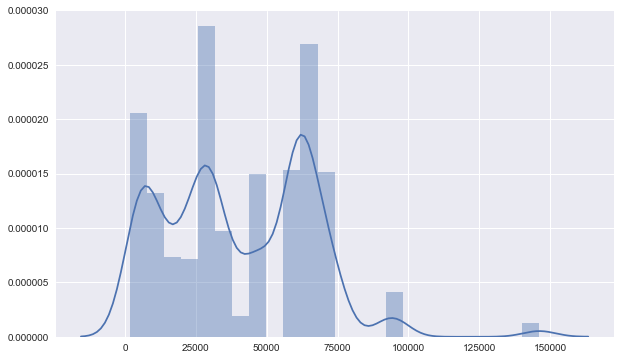

In [153]:
plt.figure(figsize=(10,6))
sns.distplot(spreads);

In [154]:
np.log(np.std(mqps))

9.960482652608281

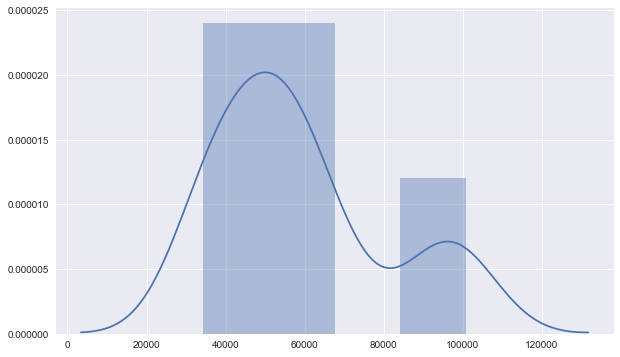

In [155]:
plt.figure(figsize=(10,6))
sns.distplot(mqps);

In [16]:
np.mean(ZI_agent_arrival)

13.420156564068678

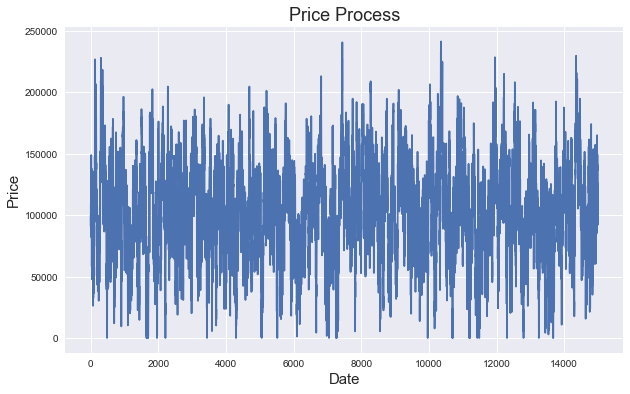

In [17]:
plt.figure(figsize=(10,6))
plt.plot(r)
plt.title("Price Process", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.show()